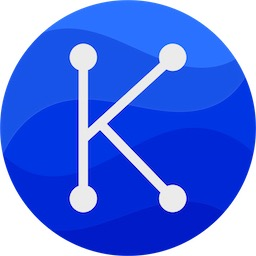


# Kymatio 2022 - Tutorial Session 1D

## One or Two Frequencies ? The scattering transform answers.

This tutorial is partially based on the paper *One or Two Frequencies?
The Scattering Transform Answers*, that you can find [here](https://arxiv.org/pdf/2003.01037.pdf).

We want to demonstrate the ability of the scattering transform to characterize auditory masking.


### 0. Requirements

For this tutorial you will need : 

* `Kymatio` : 
`pip install kymatio` or see
[link](https://www.kymat.io/)

* `pytorch` : 
[link](https://pytorch.org/get-started/locally/)

* `openL3` : 
`pip install openl3` or see
[link](https://openl3.readthedocs.io/en/latest/installation.html)

* `sklearn` : `pip install -U scikit-learn` or see [link](https://scikit-learn.org/stable/install.html)

* and `numpy`, `scipy`, `tqdm`

### 1. Synthetic data generation

In [13]:
import scipy.signal
import kymatio
import numpy as np
import random
import scipy.signal
import torch
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import tqdm
from sklearn.manifold import Isomap

This function build one sample of complex tones according to the following additive synthesis model: 


$  \boldsymbol{y}_{\alpha,r}(t) =
    \sum_{n=1}^{N}
    \dfrac{
    1 + (-1)^{n} r
    }{
    n^{\alpha}
    }
    \cos(n f_1 t)
    \boldsymbol{\phi}_T(t)
$

What do $\alpha$ and $r$ control ?

In [87]:
def generate(fourier_decay, odd_to_even, f0=[16], N=2**10):
    f0_choice = random.choice(f0)
    n_partials = int(N/(2*f0_choice)) - 1
    t = np.linspace(0, 1, N, endpoint=False)
    partials = np.zeros((n_partials, N))
    for partial_id in range(n_partials):
        frequency = (1+partial_id) * f0_choice
        amplitude = (1+odd_to_even*(-((partial_id)%2)**2))/(1+partial_id)**fourier_decay
        partial = amplitude * np.cos(2*np.pi*frequency*t)
        partials[partial_id, :] = partial
        
    x = np.sum(partials, axis=0) * scipy.signal.hann(N)

    return (x , f0_choice)

Let's now plot and see the dataset (in time and frequency), with different $\alpha$ and $r$:

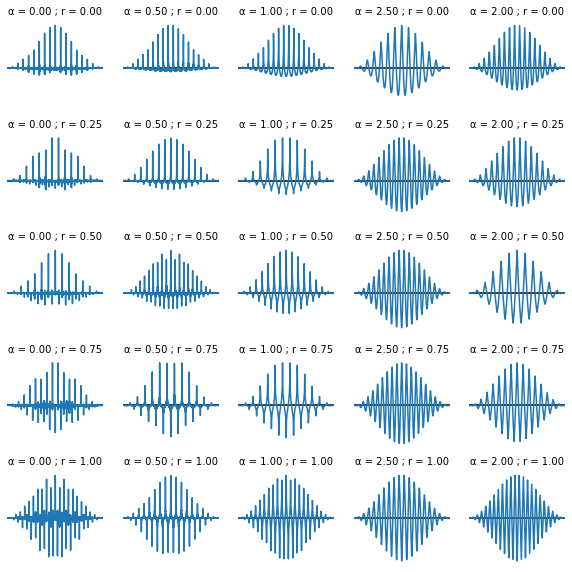

In [93]:
N = 2**10
f0_list = range(12,24)

alphas = np.ravel(np.tile(np.array([0, 0.5, 1.0, 2.5, 2.0]), (1, 5)))
rs = np.ravel(np.tile(np.array([0, 0.25, 0.5, 0.75, 1.0]), (5, 1)).T)
fig, axs = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

signals = []

 
for i in range(len(alphas)):
    a = alphas[i]
    r = rs[i]
    x, _ = generate(a, r, f0=f0_list, N=N)
    x = x/np.max(x)
    signals.append(x)
    axs[i].plot(0*x, 'k')
    axs[i].plot(x)
    axs[i].set_xlim(0, N)
    axs[i].set_ylim(-1.1, 1.1)
    axs[i].set_title("α = {:.2f} ; r = {:.2f}".format(a, r), fontsize=10)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].grid('on', linestyle='--', alpha=0.5)
 

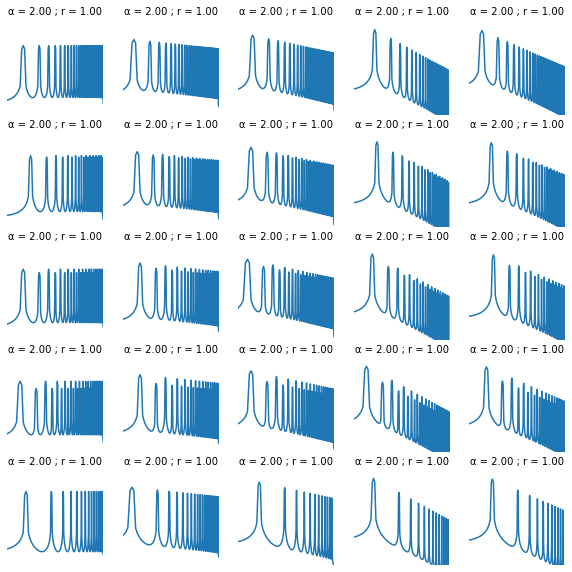

In [29]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(len(alphas)):
    x = signals[i]
    axs[i].plot(np.log2(N*t[1:(1+N//2)]), np.log10(np.abs(np.fft.rfft(x)))[1:])
    axs[i].set_ylim(-5, 3)
    axs[i].set_title("α = {:.2f} ; r = {:.2f}".format(a, r), fontsize=10)
    axs[i].set_xlim(3, 9)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)

You can alos listen to the synthetic sound, and play with different values of $\alpha$ and $r$, with a fixed f0. 

In [30]:

from ipywidgets import interactive
from IPython.display import Audio, display
import numpy as np

def render(alpha, r):
    signal = generate(alpha, r, f0=[256], N=2**15)
    rate = 22050
    display(Audio(data=signal, rate=rate, autoplay=True))
    return signal * 0.5
    
v = interactive(render, alpha=(0.0, 2.0), r=(0.0, 1.0))
display(v)

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0), FloatSlider(value=0.5, description…

Finally, we now geneate the dataset, for all $alpha$s and $r$s chosen, with a varying f0. We refer to this dataset as the complex dataset. 

In [89]:
n_alpha = 50
n_r = 50

min_alpha = 0.0
max_alpha = 2.0
min_r = 0.0
max_r = 1.0

r_range = np.linspace(min_r, max_r, n_r, endpoint=True)
alpha_range = np.linspace(min_alpha, max_alpha, n_alpha, endpoint=True)
frequencies = np.zeros((n_r, n_alpha))


X = np.zeros((n_r, n_alpha, N))
for i, r in tqdm.tqdm(enumerate(r_range), total=len(r_range)):
    for j, a in enumerate(alpha_range):
        X[i, j, :], frequencies[i, j]  = generate(a, r, f0=f0_list, N=N)

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 49.18it/s]


In [72]:
 generate(a, r, f0=f0_list, N=N)

(array([ 0.00000000e+00,  1.54808886e-07, -2.01120900e-06, ...,
         6.05477858e-07, -5.02806993e-07,  0.00000000e+00]),
 range(12, 24))

We also create a simpler dataset, with a fixed value of f0. We refer to the this dataset as the simple dataset. 


In [75]:
n_alpha = 50
n_r = 50

min_alpha = 0.0
max_alpha = 2.0
min_r = 0.0
max_r = 1.0

r_range = np.linspace(min_r, max_r, n_r, endpoint=True)
alpha_range = np.linspace(min_alpha, max_alpha, n_alpha, endpoint=True)

X_simple = np.zeros((n_r, n_alpha, N))
for i, r in tqdm.tqdm(enumerate(r_range), total=len(r_range)):
    for j, a in enumerate(alpha_range):
        X_simple[i, j, :], _ = generate(a, r, f0=[16], N=N)

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 46.72it/s]


### 2. Representations

The goal here is to see, depending on the representation of the audio signals, if we can learn an embedding that capture the parameters of our data ($\alpha$ and $r$). 
To do so, we will usr the Isomap algorithm ([link](https://www.science.org/doi/pdf/10.1126/science.290.5500.2319?casa_token=3jO92IQhP-oAAAAA:BsWxsyAUddTwP8NUO0GY7YZ-L2CiuSX4iTfevpySjfsJmcokM8SqaFN1v3gigDWH02fmlrFbd6mmEfbN) ) for unsupervised manifold learning.

We will compare applying it on either the waveform and scattering transform of the signals, on the simple dataset (one f0) and the complex dataset (sample f0). 

In [54]:
def make_maifold(Xmat, n_compenents=2, n_neighbors=50, n_r=50, n_alpha=50, N=2**10):


    raw_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    raw_iso = raw_isomap.fit_transform(Xmat)
    raw_isoReshape = raw_iso.reshape((n_r, n_alpha, n_components))
    
    return raw_isoReshape


In [57]:
n_compenents=2
n_neighbors=50
Xmat_simple = X_simple.reshape((n_r*n_alpha, N))

raw_isoReshape = make_maifold(Xmat_simple, n_compenents, n_neighbors, n_r, n_alpha, N)

Now, to visualize the manifold, for the simple dataset. This manifold is learn directly on the waveform, without transforming the generated audio signal. 

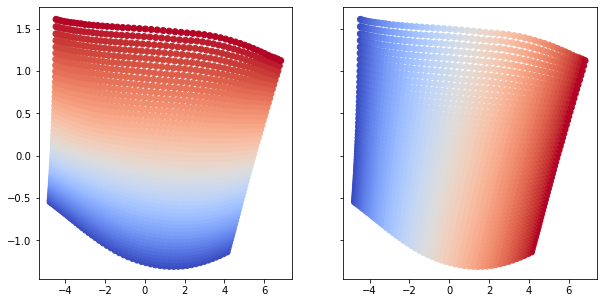

In [58]:
alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
axs[0].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');

Let's see how things go with the more complex dataset :

/home/cohenhadria/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 12 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/cohenhadria/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cohenhadria/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/cohenhadria/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is mo

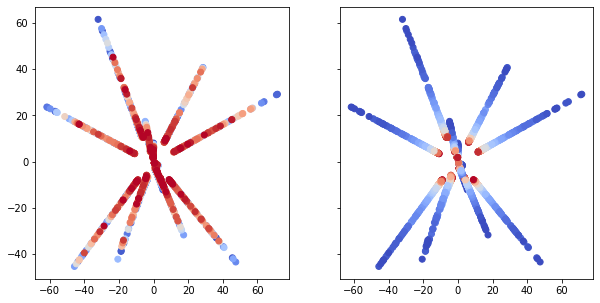

In [90]:
Xmat = X.reshape((n_r*n_alpha, N))


raw_isoReshape = make_maifold(Xmat)


alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
axs[0].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');

What differences can you see between the two manifolds ?

Let's try it with the scattering transform.

In [60]:
def make_scattering(X, n_r=50, n_alpha=50, N=2**10):

    Xmat = X.reshape((n_r*n_alpha, N))

    scattering = kymatio.Scattering1D(J=int(np.log2(N)), Q=1, shape=(N,))
    Xmat_torch = torch.from_numpy(Xmat).float()
    Smat = np.maximum(0, scattering(Xmat_torch).numpy()[:, :, 0])
    return Smat

In [61]:
Smat = make_scattering(X_simple)

/home/cohenhadria/anaconda3/envs/tf/lib/python3.9/site-packages/kymatio/frontend/entry.py:20: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  warnings.warn("Torch frontend is currently the default, but NumPy will become the default in the next"


And now, learn a manifold for this matrix

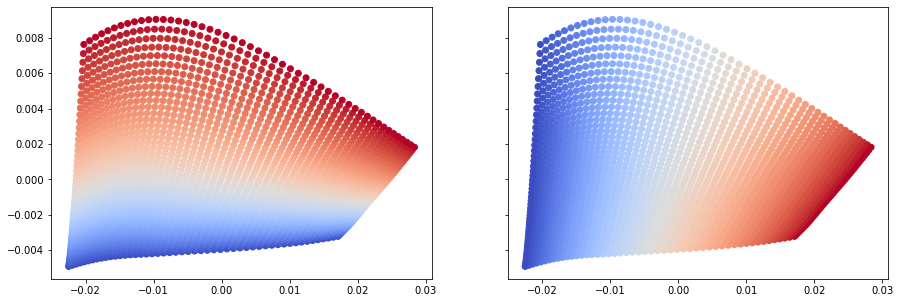

In [83]:

n_components = 3
n_neighbors = 100

manifold_scattering = make_maifold(Smat, n_compenents, n_neighbors)

alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;


fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)
axs = axs.flatten()

axs[0].scatter(
    np.ravel(manifold_scattering[:, :, 0]),
    np.ravel(manifold_scattering[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(manifold_scattering[:, :, 0]),
    np.ravel(manifold_scattering[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');


Now, we do the same but with the complex dataset.

In [91]:
Smat = make_scattering(X)

n_components = 3
n_neighbors = 100

manifold_scattering = make_maifold(Smat, n_compenents, n_neighbors)

/home/cohenhadria/anaconda3/envs/tf/lib/python3.9/site-packages/kymatio/frontend/entry.py:20: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  warnings.warn("Torch frontend is currently the default, but NumPy will become the default in the next"


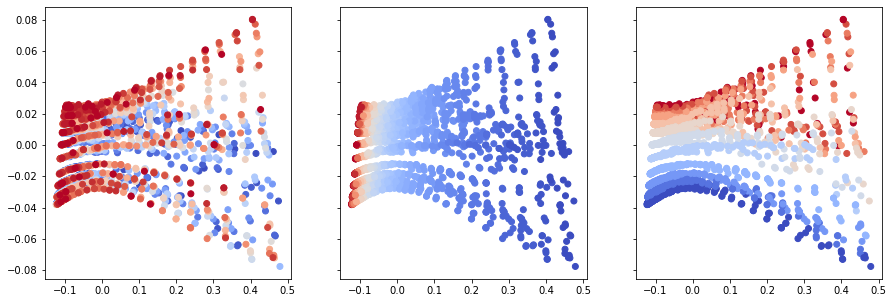

In [92]:
alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=True)
axs = axs.flatten()

axs[0].scatter(
    np.ravel(manifold_scattering[:, :, 0]),
    np.ravel(manifold_scattering[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(manifold_scattering[:, :, 0]),
    np.ravel(manifold_scattering[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');
axs[2].scatter(
    np.ravel(manifold_scattering[:, :, 0]),
    np.ravel(manifold_scattering[:, :, 1]),
    c = np.ravel(frequencies), cmap='coolwarm');